In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [4]:
from utilities import *

In [5]:
import functools

In [6]:
%matplotlib inline
plt.ioff()
sns.set()

[Dataset](https://analyse.kmi.open.ac.uk/open_dataset) can be found here along with the schema and description below

Database Schema:

<img src='./schema.png'>

### courses.csv
File contains the list of all available modules and their presentations. The columns are:
- code_module – code name of the module, which serves as the identifier.
- code_presentation – code name of the presentation. It consists of the year and “B” for the presentation starting in February and “J” for the presentation starting in October.
- length - length of the module-presentation in days.
- The structure of B and J presentations may differ and therefore it is good practice to analyse the B and J presentations separately. Nevertheless, for some presentations the corresponding previous B/J presentation do not exist and therefore the J presentation must be used to inform the B presentation or vice versa. In the dataset this is the case of CCC, EEE and GGG modules.

### assessments.csv
This file contains information about assessments in module-presentations. Usually, every presentation has a number of assessments followed by the final exam. CSV contains columns:
- code_module – identification code of the module, to which the assessment belongs.
- code_presentation - identification code of the presentation, to which the assessment belongs.
- id_assessment – identification number of the assessment.
- assessment_type – type of assessment. Three types of assessments exist: Tutor Marked Assessment (TMA), Computer Marked Assessment (CMA) and Final Exam (Exam).
- date – information about the final submission date of the assessment calculated as the number of days since the start of the module-presentation. The starting date of the presentation has number 0 (zero).
- weight - weight of the assessment in %. Typically, Exams are treated separately and have the weight 100%; the sum of all other assessments is 100%.
- If the information about the final exam date is missing, it is at the end of the last presentation week.

### vle.csv
The csv file contains information about the available materials in the VLE. Typically these are html pages, pdf files, etc. Students have access to these materials online and their interactions with the materials are recorded. The vle.csv file contains the following columns:
- id_site – an identification number of the material.
- code_module – an identification code for module.
- code_presentation - the identification code of presentation.
- activity_type – the role associated with the module material.
- week_from – the week from which the material is planned to be used.
- week_to – week until which the material is planned to be used.

### studentInfo.csv
This file contains demographic information about the students together with their results. File contains the following columns:
- code_module – an identification code for a module on which the student is registered.
- code_presentation - the identification code of the presentation during which the student is registered on the module.
- id_student – a unique identification number for the student.
- gender – the student’s gender.
- region – identifies the geographic region, where the student lived while taking the module-presentation.
- highest_education – highest student education level on entry to the module presentation.
- imd_band – specifies the Index of Multiple Depravation band of the place where the student lived during the module-presentation.
- age_band – band of the student’s age.
- num_of_prev_attempts – the number times the student has attempted this module.
- studied_credits – the total number of credits for the modules the student is currently studying.
- disability – indicates whether the student has declared a disability.
- final_result – student’s final result in the module-presentation.

### studentRegistration.csv
This file contains information about the time when the student registered for the module presentation. For students who unregistered the date of unregistration is also recorded. File contains five columns:
- code_module – an identification code for a module.
- code_presentation - the identification code of the presentation.
- id_student – a unique identification number for the student.
- date_registration – the date of student’s registration on the module presentation, this is the number of days measured relative to the start of the module-presentation (e.g. the negative value -30 means that the student registered to module presentation 30 days before it started).
- date_unregistration – date of student unregistration from the module presentation, this is the number of days measured relative to the start of the module-presentation. Students, who completed the course have this field empty. Students who unregistered have Withdrawal as the value of the final_result column in the studentInfo.csv file.

### studentAssessment.csv
This file contains the results of students’ assessments. If the student does not submit the assessment, no result is recorded. The final exam submissions is missing, if the result of the assessments is not stored in the system. This file contains the following columns:
- id_assessment – the identification number of the assessment.
- id_student – a unique identification number for the student.
- date_submitted – the date of student submission, measured as the number of days since the start of the module presentation.
- is_banked – a status flag indicating that the assessment result has been transferred from a previous presentation.
- score – the student’s score in this assessment. The range is from 0 to 100. The score lower than 40 is interpreted as Fail. The marks are in the range from 0 to 100.

### studentVle.csv
The studentVle.csv file contains information about each student’s interactions with the materials in the VLE. This file contains the following columns:
- code_module – an identification code for a module.
- code_presentation - the identification code of the module presentation.
- id_student – a unique identification number for the student.
- id_site - an identification number for the VLE material.
- date – the date of student’s interaction with the material measured as the number of days since the start of the module-presentation.
- sum_click – the number of times a student interacts with the material in that day.

In [5]:
files = os.listdir('./anonymisedData/')
files

['studentAssessment.csv',
 'studentInfo.csv',
 'studentVle.csv',
 'courses.csv',
 'vle.csv',
 'studentRegistration.csv',
 'assessments.csv']

In [6]:
data = {}
for file_name in files:
    data[file_name[:-4]] = pd.read_csv(f'./anonymisedData/{file_name}')

In [15]:
def plot(fn, *args, **kwargs):
    if 'figsize' in kwargs:
        fig, ax = plt.subplots(figsize = kwargs['figsize'])
        del kwargs['figsize']
    else:
        fig, ax = plt.subplots()
    kwargs['ax'] = ax
    fn(*args, **kwargs)
    return fig

In [16]:
sns.set()

#### When did students start the class

In [9]:
df = data['studentVle']

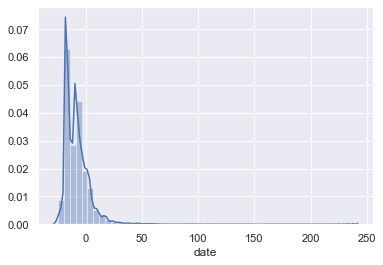

In [10]:
plot(sns.distplot, df.groupby('id_student')['date'].min().sort_values())

#### When did classes run and how many students per class

In [11]:
pt = df.pivot_table(values = 'id_student', index = 'code_module', columns = 'code_presentation',
                    aggfunc= lambda s : len(set(s)))

In [12]:
pt

code_presentation,2013B,2013J,2014B,2014J
code_module,,,,
AAA,NaN,378.0,NaN,357.0
BBB,1537.0,1870.0,1294.0,1921.0
CCC,NaN,NaN,1681.0,2302.0
DDD,1214.0,1768.0,1116.0,1647.0
EEE,NaN,964.0,624.0,1097.0
FFF,1510.0,2098.0,1363.0,2121.0
GGG,NaN,895.0,773.0,698.0


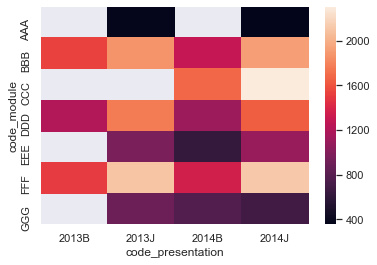

In [13]:
plot(sns.heatmap, pt)

#### How many classes did each student take? And how many were distinct classes?

Some students took up to 3 different modules:

In [14]:
df[['id_student', 'code_module']].drop_duplicates().groupby('id_student').apply(len).value_counts()

1    23923
2     2139
3       12
dtype: int64

One student repeated a the same module 4 times! 

In [15]:
df[['id_student', 'code_module', 'code_presentation']].drop_duplicates().groupby(['code_module', 'id_student']).apply(len).value_counts()

1    27267
2      950
3       19
4        1
dtype: int64

#### When were materials available?

In [16]:
df.date.value_counts().sort_index()

-25     4291
-24     3887
-23     2618
-22     1728
-21     1283
        ... 
 265    1401
 266     955
 267    1113
 268    1618
 269     814
Name: date, Length: 295, dtype: int64

#### What materials are there – count by module and presentation

In [17]:
df[['code_module', 'code_presentation', 'id_site']].drop_duplicates().groupby(['code_module', 'code_presentation']).apply(len)

code_module  code_presentation
AAA          2013J                209
             2014J                197
BBB          2013B                315
             2013J                320
             2014B                311
             2014J                206
CCC          2014B                180
             2014J                220
DDD          2013B                408
             2013J                456
             2014B                447
             2014J                361
EEE          2013J                107
             2014B                104
             2014J                110
FFF          2013B                500
             2013J                526
             2014B                475
             2014J                449
GGG          2013J                137
             2014B                124
             2014J                106
dtype: int64

#### What is the distribution of interactions by material?

In [18]:
popularity = df.groupby(['code_module', 'code_presentation', 'id_site'])['sum_click'].sum()

In [19]:
popularity

code_module  code_presentation  id_site
AAA          2013J              546614     140345
                                546644      22228
                                546645       7621
                                546647       3844
                                546648       1959
                                            ...  
GGG          2014J              897150       4926
                                897151      11575
                                897152        695
                                897153        165
                                897154        127
Name: sum_click, Length: 6268, dtype: int64

In [20]:
popularity[popularity == 1]

code_module  code_presentation  id_site
AAA          2013J              546906     1
                                546914     1
                                546919     1
                                546955     1
                                546985     1
                                          ..
GGG          2014B              798784     1
                                798791     1
                                798804     1
                                798806     1
                                798816     1
Name: sum_click, Length: 138, dtype: int64

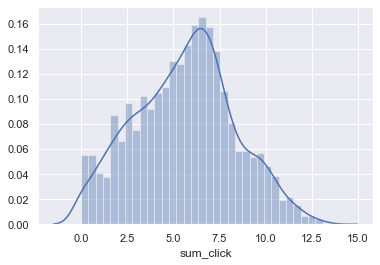

In [21]:
plot(sns.distplot, np.log(popularity))

In [22]:
ln_popularity = np.log(popularity).reset_index()

In [23]:
ln_popularity

,code_module,code_presentation,id_site,sum_click
0,AAA,2013J,546614,11.851859
1,AAA,2013J,546644,10.009108
2,AAA,2013J,546645,8.938663
3,AAA,2013J,546647,8.254269
4,AAA,2013J,546648,7.580189
...,...,...,...,...
6263,GGG,2014J,897150,8.502283
6264,GGG,2014J,897151,9.356603
6265,GGG,2014J,897152,6.543912
6266,GGG,2014J,897153,5.105945


In [24]:
g = sns.FacetGrid(ln_popularity, col = 'code_module', hue = 'code_presentation')

In [25]:
g = g.map(sns.distplot, 'sum_click')

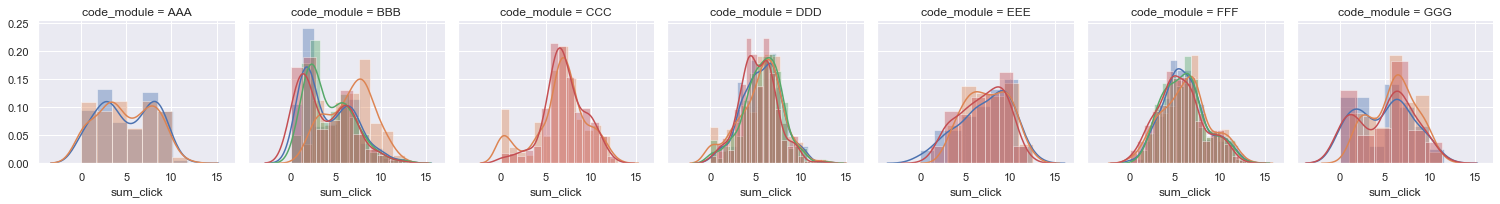

In [26]:
g.fig

Possible features:
- Alignment with the rest of the class (is a student having the same distribution?)

# Actual Feature Engineering

In [27]:
data.keys()

dict_keys(['studentAssessment', 'studentInfo', 'studentVle', 'courses', 'vle', 'studentRegistration', 'assessments'])

In [28]:
data['courses'].head(1)

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268


In [29]:
data['studentRegistration'].head(1)

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN


#### We are most interested in joining studentVLE with VLE information to get more data about the clicks

In [30]:
data['vle'].head(1)

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN


In [31]:
data['vle'].activity_type.value_counts(dropna = False)

resource          2660
subpage           1055
oucontent          996
url                886
forumng            194
quiz               127
page               102
oucollaborate       82
questionnaire       61
ouwiki              49
dataplus            28
externalquiz        26
homepage            22
glossary            21
ouelluminate        21
dualpane            20
repeatactivity       5
htmlactivity         4
sharedsubpage        3
folder               2
Name: activity_type, dtype: int64

In [32]:
data['vle'].week_from.value_counts(dropna = False).head()

NaN     5243
18.0      91
1.0       84
28.0      63
9.0       52
Name: week_from, dtype: int64

In [33]:
data['vle'].week_to.value_counts(dropna = False).head(5)

NaN     5243
18.0      91
1.0       80
28.0      63
9.0       54
Name: week_to, dtype: int64

In [34]:
data['vle'].groupby('activity_type')[['week_from', 'week_to']].agg([lambda date_ : sum(date_.isna()), 
                                                                    lambda date_ : sum(~date_.isna())])

week_from               week_to           
               <lambda_0> <lambda_1> <lambda_0> <lambda_1>
activity_type                                             
dataplus             26.0        2.0       26.0        2.0
dualpane             15.0        5.0       15.0        5.0
externalquiz         26.0        0.0       26.0        0.0
folder                2.0        0.0        2.0        0.0
forumng             194.0        0.0      194.0        0.0
glossary             21.0        0.0       21.0        0.0
homepage             22.0        0.0       22.0        0.0
htmlactivity          4.0        0.0        4.0        0.0
oucollaborate        82.0        0.0       82.0        0.0
oucontent           615.0      381.0      615.0      381.0
ouelluminate         21.0        0.0       21.0        0.0
ouwiki               43.0        6.0       43.0        6.0
page                 69.0       33.0       69.0       33.0
questionnaire        19.0       42.0       19.0       42.0
quiz                114.0       13.0      114.0       13.0
repeatactivity        1.0        4.0        1.0        4.0
resource           2512.0      148.0     2512.0      148.0
sharedsubpage         3.0        0.0        3.0        0.0
subpage             920.0      135.0      920.0      135.0
url                 534.0      352.0      534.0      352.0

In [35]:
df = data['studentVle'].merge(data['vle'],
                              on = ['id_site', 'code_module', 'code_presentation'], 
                              how = 'outer', 
                              indicator = True, 
                              validate = 'm:1')

In [36]:
df.head()

,code_module,code_presentation,id_student,id_site,date,sum_click,activity_type,week_from,week_to,_merge
0,AAA,2013J,28400.0,546652,-10.0,4.0,forumng,NaN,NaN,both
1,AAA,2013J,28400.0,546652,-10.0,1.0,forumng,NaN,NaN,both
2,AAA,2013J,28400.0,546652,-10.0,1.0,forumng,NaN,NaN,both
3,AAA,2013J,28400.0,546652,-10.0,8.0,forumng,NaN,NaN,both
4,AAA,2013J,30268.0,546652,-10.0,3.0,forumng,NaN,NaN,both


In [37]:
df._merge.value_counts()

both          10655280
right_only          96
left_only            0
Name: _merge, dtype: int64

In [38]:
df = data['studentVle'].merge(data['vle'],
                              on = ['id_site', 'code_module', 'code_presentation'], 
                              how = 'left', 
                              validate = 'm:1')

In [39]:
df.head()

,code_module,code_presentation,id_student,id_site,date,sum_click,activity_type,week_from,week_to
0,AAA,2013J,28400,546652,-10,4,forumng,NaN,NaN
1,AAA,2013J,28400,546652,-10,1,forumng,NaN,NaN
2,AAA,2013J,28400,546652,-10,1,forumng,NaN,NaN
3,AAA,2013J,28400,546614,-10,11,homepage,NaN,NaN
4,AAA,2013J,28400,546714,-10,1,oucontent,NaN,NaN


In [40]:
# Add the course info
df = df.merge(data['courses'], on = ['code_module', 'code_presentation'])

In [41]:
index, student_df = next(iter(df.groupby(['code_module', 'code_presentation', 'id_student'])))

In [42]:
index

('AAA', '2013J', 11391)

In [43]:
student_df

,code_module,code_presentation,id_student,id_site,date,sum_click,activity_type,week_from,week_to,module_presentation_length
6758,AAA,2013J,11391,546669,-5,16,oucontent,NaN,NaN,268
6759,AAA,2013J,11391,546662,-5,44,oucontent,NaN,NaN,268
6760,AAA,2013J,11391,546652,-5,1,forumng,NaN,NaN,268
6761,AAA,2013J,11391,546668,-5,2,oucontent,NaN,NaN,268
6762,AAA,2013J,11391,546652,-5,1,forumng,NaN,NaN,268
...,...,...,...,...,...,...,...,...,...,...
176954,AAA,2013J,11391,546733,242,4,oucontent,NaN,NaN,268
178915,AAA,2013J,11391,546644,245,2,forumng,NaN,NaN,268
178916,AAA,2013J,11391,546644,245,3,forumng,NaN,NaN,268
178917,AAA,2013J,11391,546614,245,2,homepage,NaN,NaN,268


In [44]:
def get_activity_dist_stats(student_df):
    dist = get_click_day_dist(student_df)
    return pd.Series({
      'mean_activity_day' : dist.mean(),
      'activity_skew'     : dist.skew()
    })

def get_click_day_dist(student_df):
    return pd.Series(student_df.apply(lambda s : [s['date']] * s.sum_click, axis = 'columns').sum())

In [45]:
def get_activity_hist_stats(student_df):
    out_dict = {}
    module_length             = student_df.module_presentation_length.iloc[0]

    activity_by_day           = student_df.groupby('date')['sum_click'].sum()
    out_dict['daily_variability_active']  = activity_by_day.std()
    out_dict['days_worked']               = len(activity_by_day)
    activity_by_week          = activity_by_day.rename(lambda day : day // 7).reset_index().groupby('date').sum()
    out_dict['weekly_variability']        = activity_by_week.sum_click.std()

    min_day = activity_by_day.index.min()
    max_day = max(activity_by_day.index.max(), module_length)
    activity_by_day           = activity_by_day.reindex(range(min_day, max_day)).fillna(0)

    out_dict['daily_variability_all']     = activity_by_day.std()

    return pd.Series(out_dict)

In [46]:
# These can be defined with a NamedAgg in pandas >= 0.25
#  (which would likely be slightly faster)
#  but are included here for consistency of the setup
def get_simple_stats(student_df):
    out_dict = {}
    out_dict['first_click']  = student_df['date'].min()
    out_dict['last_click']   = student_df['date'].max()
    out_dict['total_clicks'] = student_df.sum_click.sum()
    return pd.Series(out_dict)

In [47]:
def get_timeliness_stats(student_df):
    out_dict = {}
    
    student_df = student_df.dropna(subset = ['week_from', 'week_to'])
    out_dict['mean_click_time_from_release'] =  mean_time_to_week(student_df, 'week_from')
    out_dict['mean_click_time_to_close']     = -mean_time_to_week(student_df, 'week_to'  )
    
    return pd.Series(out_dict)
    
# No need to worry about exactly what day the week starts on.
#  Any shift (e.g. Sunday to Monday) will produce a constant shift equivariant
#  across students
def mean_time_to_week(student_df, week_col):
    return ((student_df['date'] - 7*student_df[week_col]) * student_df.sum_click).mean()

In [48]:
# Will cause multi-collinearity with sum of clicks. Use with caution
def get_clicks_by_content_type(student_df):
    temp_df = student_df.groupby('activity_type')['sum_click'].sum()
    temp_df = temp_df.rename(lambda index : f'clicks_{index}')
    return temp_df
    

For our last feature, we want to measure whether the student was looking at the same material as the class as a whole. To assess this, we treat the class' overall activity as a probability distribution of clicks over the different materials.

Then we get to use one of the various statistical tests to compare the distributions. We will try a variety of tests. Realistically, we expect them to be highly correlated. So the variety is more for fun than profit.

We restrict ourselves to the class of [f-divergences](https://en.wikipedia.org/wiki/F-divergence). This includes:
1. The KL divergence
2. The (squared) Hellinger distance
3. The $\chi^2$ goodness-of-fit score
4. The total variation
Notable exclusions: [Cramer von Mises](https://en.wikipedia.org/wiki/Cram%C3%A9r%E2%80%93von_Mises_criterion), [Jensen-Shannon](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence)

We can't do the KL divergence because it is infinite when the distributions don't have the same support.

In [49]:
student_df

,code_module,code_presentation,id_student,id_site,date,sum_click,activity_type,week_from,week_to,module_presentation_length
6758,AAA,2013J,11391,546669,-5,16,oucontent,NaN,NaN,268
6759,AAA,2013J,11391,546662,-5,44,oucontent,NaN,NaN,268
6760,AAA,2013J,11391,546652,-5,1,forumng,NaN,NaN,268
6761,AAA,2013J,11391,546668,-5,2,oucontent,NaN,NaN,268
6762,AAA,2013J,11391,546652,-5,1,forumng,NaN,NaN,268
...,...,...,...,...,...,...,...,...,...,...
176954,AAA,2013J,11391,546733,242,4,oucontent,NaN,NaN,268
178915,AAA,2013J,11391,546644,245,2,forumng,NaN,NaN,268
178916,AAA,2013J,11391,546644,245,3,forumng,NaN,NaN,268
178917,AAA,2013J,11391,546614,245,2,homepage,NaN,NaN,268


In [50]:
# Following the analysis we did above, compute the distribution for each class
popularity = df.groupby(['code_module', 'code_presentation', 'id_site'])['sum_click'].sum()
popularity = popularity.groupby(['code_module', 'code_presentation']).transform(lambda counts : counts / counts.sum())

# And compare to the student
def get_alignment_scores(student_df):
    out_dict = {}

    student_dist = student_df.groupby(['code_module', 'code_presentation', 'id_site'])['sum_click'].sum()
    student_dist = student_dist / student_dist.sum()

    class_ = student_dist.index[0][:2]
    student_dist.index = (student_dist.index.droplevel(['code_module', 'code_presentation']))

    cmp_dist = popularity[class_]
    out_dict['num_materials_used'] = len(student_dist)
    out_dict['num_materials_available'] = len(cmp_dist)

    student_dist = student_dist.reindex(cmp_dist.index, fill_value = 0)

    f_score = functools.partial(get_f_divergence, student_dist, cmp_dist)
    divergences = {
        'attention_hellinger_squared' : lambda ratios : (np.sqrt(ratios) - 1)**2,
        'attention_total_variation'   : lambda ratios : np.abs(ratios - 1) / 2,
        'attention_chi_sq_gof'        : lambda ratios : (ratios - 1)**2 # Varies by a factor of n
    }
    divergences = {k : f_score(v) for k, v in divergences.items()}

    return pd.Series(dict(**out_dict, **divergences))


def get_f_divergence(p, q, f):
    return (f(p / q) * q).sum()

In [51]:
def get_all_features(student_df):
    return pd.concat(map(
        lambda func : func(student_df),
        [get_timeliness_stats, 
         get_clicks_by_content_type,
         get_activity_dist_stats,
         get_activity_hist_stats,
         get_simple_stats,
         get_alignment_scores
        ]
    )).transpose()

In [52]:
# WARNING: This takes about 20 minutes on my machine

In [53]:
Timer.start()
#feature_df = df.groupby(['code_module', 'code_presentation', 'id_student']).apply(get_all_features).unstack()
Timer.end()

0.0 seconds elapsed


In [54]:
# feature_df.to_csv('click_features.csv')

In [107]:
feature_df = pd.read_csv('click_features.csv')

In [56]:
len(feature_df)

29228

In [57]:
feature_df.head(10)

,code_module,code_presentation,id_student,activity_skew,attention_chi_sq_gof,attention_hellinger_squared,attention_total_variation,clicks_dataplus,clicks_dualpane,clicks_externalquiz,...,days_worked,first_click,last_click,mean_activity_day,mean_click_time_from_release,mean_click_time_to_close,num_materials_available,num_materials_used,total_clicks,weekly_variability
0,AAA,2013J,11391,0.741381,2.736682,0.385076,0.401765,NaN,NaN,NaN,...,40.0,-5.0,253.0,80.692719,108.090909,-108.090909,209.0,55.0,934.0,40.992738
1,AAA,2013J,28400,0.334122,0.763697,0.151137,0.255698,10.0,NaN,NaN,...,80.0,-10.0,239.0,83.399303,-56.083333,56.083333,209.0,84.0,1435.0,38.534345
2,AAA,2013J,30268,-0.314198,3.103162,0.660523,0.504224,NaN,NaN,NaN,...,12.0,-10.0,12.0,3.409253,-13.625000,13.625000,209.0,22.0,281.0,40.136226
3,AAA,2013J,31604,0.256927,0.327877,0.124606,0.200600,2.0,NaN,NaN,...,123.0,-10.0,264.0,102.620945,153.000000,-153.000000,209.0,82.0,2158.0,39.918266
4,AAA,2013J,32885,0.849391,2.519574,0.361038,0.403652,NaN,NaN,NaN,...,70.0,-10.0,247.0,67.068665,41.076923,-41.076923,209.0,66.0,1034.0,41.159485
5,AAA,2013J,38053,-0.008823,0.338421,0.098247,0.195052,7.0,NaN,NaN,...,143.0,-10.0,267.0,113.847444,433.850000,-433.850000,209.0,88.0,2445.0,71.586226
6,AAA,2013J,45462,0.243834,1.167415,0.343420,0.352371,2.0,NaN,NaN,...,90.0,-10.0,267.0,98.495979,49.642857,-49.642857,209.0,59.0,1492.0,43.049489
7,AAA,2013J,45642,0.258029,0.865333,0.239639,0.278939,4.0,NaN,NaN,...,105.0,-9.0,264.0,108.079832,342.521739,-342.521739,209.0,66.0,1428.0,37.016858
8,AAA,2013J,52130,0.020442,0.581814,0.186473,0.283564,8.0,NaN,NaN,...,122.0,-4.0,245.0,119.409187,40.571429,-40.571429,209.0,76.0,1894.0,46.737124
9,AAA,2013J,53025,0.061989,1.335719,0.247065,0.391263,3.0,NaN,NaN,...,142.0,-7.0,257.0,109.386004,-55.250000,55.250000,209.0,80.0,3158.0,53.942467


In [58]:
feature_df.columns

Index(['code_module', 'code_presentation', 'id_student', 'activity_skew',
       'attention_chi_sq_gof', 'attention_hellinger_squared',
       'attention_total_variation', 'clicks_dataplus', 'clicks_dualpane',
       'clicks_externalquiz', 'clicks_folder', 'clicks_forumng',
       'clicks_glossary', 'clicks_homepage', 'clicks_htmlactivity',
       'clicks_oucollaborate', 'clicks_oucontent', 'clicks_ouelluminate',
       'clicks_ouwiki', 'clicks_page', 'clicks_questionnaire', 'clicks_quiz',
       'clicks_repeatactivity', 'clicks_resource', 'clicks_sharedsubpage',
       'clicks_subpage', 'clicks_url', 'daily_variability_active',
       'daily_variability_all', 'days_worked', 'first_click', 'last_click',
       'mean_activity_day', 'mean_click_time_from_release',
       'mean_click_time_to_close', 'num_materials_available',
       'num_materials_used', 'total_clicks', 'weekly_variability'],
      dtype='object')

# Part 2: Put together the student data

In [59]:
data.keys()

dict_keys(['studentAssessment', 'studentInfo', 'studentVle', 'courses', 'vle', 'studentRegistration', 'assessments'])

In [60]:
# Assessements are unique
data['assessments'].groupby('id_assessment').apply(len).value_counts()

1    206
dtype: int64

#### Let's look at the final exams

In [61]:
finals = data['assessments'][data['assessments'].assessment_type == 'Exam']
finals.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0


In [62]:
# Some classes have 2 finals
finals.groupby(['code_module', 'code_presentation']).apply(len)

code_module  code_presentation
AAA          2013J                1
             2014J                1
BBB          2013B                1
             2013J                1
             2014B                1
             2014J                1
CCC          2014B                2
             2014J                2
DDD          2013B                1
             2013J                1
             2014B                1
             2014J                1
EEE          2013J                1
             2014B                1
             2014J                1
FFF          2013B                1
             2013J                1
             2014B                1
             2014J                1
GGG          2013J                1
             2014B                1
             2014J                1
dtype: int64

In [63]:
finals[finals.code_module=='CCC']

,code_module,code_presentation,id_assessment,assessment_type,date,weight
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0


In [64]:
data['studentAssessment']

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0
...,...,...,...,...,...
173907,37443,527538,227,0,60.0
173908,37443,534672,229,0,100.0
173909,37443,546286,215,0,80.0
173910,37443,546724,230,0,100.0


In [65]:
len(data['studentRegistration'])

32593

In [66]:
data['studentAssessment'].groupby('id_student').apply(len).value_counts().sort_index()

1     1953
2     1460
3     1300
4     2008
5     2661
6      810
7     2266
8      734
9     2101
10     931
11    2231
12    3413
13     401
14     411
15      98
16     220
17      46
18      36
19      32
20      42
21     148
22      18
23      30
24      16
25       1
26       1
28       1
dtype: int64

#### Main table is student registrations

In [67]:
data['studentRegistration'].groupby('id_student').apply(len).value_counts()

1    25247
2     3293
3      221
4       23
5        1
dtype: int64

In [68]:
data['studentRegistration']

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN
...,...,...,...,...,...
32588,GGG,2014J,2640965,-4.0,NaN
32589,GGG,2014J,2645731,-23.0,NaN
32590,GGG,2014J,2648187,-129.0,NaN
32591,GGG,2014J,2679821,-49.0,101.0


In [69]:
test = data['studentAssessment'].merge(finals, how = 'outer', on = 'id_assessment', indicator = True, validate = 'm:1')

In [70]:
test.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,_merge
0,1752,11391.0,18.0,0.0,78.0,NaN,NaN,NaN,NaN,NaN,left_only
1,1752,28400.0,22.0,0.0,70.0,NaN,NaN,NaN,NaN,NaN,left_only
2,1752,31604.0,17.0,0.0,72.0,NaN,NaN,NaN,NaN,NaN,left_only
3,1752,32885.0,26.0,0.0,69.0,NaN,NaN,NaN,NaN,NaN,left_only
4,1752,38053.0,19.0,0.0,79.0,NaN,NaN,NaN,NaN,NaN,left_only


In [71]:
test._merge.value_counts()

left_only     168953
both            4959
right_only        18
Name: _merge, dtype: int64

In [72]:
test.groupby(['code_module', 'code_presentation']).apply(len)

code_module  code_presentation
AAA          2013J                   1
             2014J                   1
BBB          2013B                   1
             2013J                   1
             2014B                   1
             2014J                   1
CCC          2014B                 748
             2014J                1169
DDD          2013B                 602
             2013J                 968
             2014B                 524
             2014J                 950
EEE          2013J                   1
             2014B                   1
             2014J                   1
FFF          2013B                   1
             2013J                   1
             2014B                   1
             2014J                   1
GGG          2013J                   1
             2014B                   1
             2014J                   1
dtype: int64

In [73]:
# This validates our merge in terms of: the missing assessements are non-finals
test = data['studentAssessment'].merge(data['assessments'], how = 'outer', on = 'id_assessment', indicator = True, validate = 'm:1')
test._merge.value_counts()

both          173912
right_only        18
left_only          0
Name: _merge, dtype: int64

#### But... It turns out most classes don't have finals. Make a 'grades' table instead

In [74]:
exam_scores = data['studentAssessment'].merge(finals, how = 'inner', on = 'id_assessment')

In [75]:
exam_scores.code_module.value_counts()

DDD    3044
CCC    1915
Name: code_module, dtype: int64

Instead, look at all assessements

In [76]:
assessments = data['studentAssessment'].merge(data['assessments'], how = 'inner', on = 'id_assessment', validate = 'm:1')

In [77]:
bucket = {
    'TMA' : 'Assessment',
    'CMA' : 'Assessment',
    'Exam': 'Exam'
}

In [78]:
assessments.loc[:,'assessment_type'] = assessments.assessment_type.map(lambda name : bucket[name])

In [80]:
def agg_grades(df):
    df['score_x_weight'] = df.score * df.weight
    df = df.agg({
        'weight' : 'sum',
        'score_x_weight' : 'sum',
    })
    return df[['score_x_weight', 'weight']]

Takes about 2 minutes:

In [82]:
Timer.start()
grades = assessments.groupby(['code_module', 'code_presentation', 'id_student', 'assessment_type']).apply(agg_grades)
Timer.end()

101.541 seconds elapsed


In [83]:
grades['grade'] = grades.score_x_weight / grades.weight

In [84]:
grades.drop('score_x_weight', axis = 'columns', inplace = True)

In [85]:
grades = grades.unstack(3)

In [86]:
data['studentRegistration'].set_index(['code_module', 'code_presentation', 'id_student'], inplace = True)

In [87]:
grades.columns = pd.Index('_'.join(tuple_) for tuple_ in grades.columns)

In [88]:
grades

weight_Assessment  weight_Exam  \
code_module code_presentation id_student                                   
AAA         2013J             11391                   100.0          NaN   
                              28400                   100.0          NaN   
                              31604                   100.0          NaN   
                              32885                   100.0          NaN   
                              38053                   100.0          NaN   
...                                                     ...          ...   
GGG         2014J             2620947                   0.0          NaN   
                              2645731                   0.0          NaN   
                              2648187                   0.0          NaN   
                              2679821                   0.0          NaN   
                              2684003                   0.0          NaN   

                                          grade_Assessment  grade_Exam  
code_module code_presentation id_student                                
AAA         2013J             11391                   82.4         NaN  
                              28400                   65.4         NaN  
                              31604                   76.3         NaN  
                              32885                   55.0         NaN  
                              38053                   66.9         NaN  
...                                                    ...         ...  
GGG         2014J             2620947                  NaN         NaN  
                              2645731                  NaN         NaN  
                              2648187                  NaN         NaN  
                              2679821                  NaN         NaN  
                              2684003                  NaN         NaN  

[25843 rows x 4 columns]

In [89]:
student_grades = data['studentRegistration'].merge(grades, how = 'outer', indicator = True, 
                                                   left_index = True, right_index = True, validate = '1:1')

In [90]:
# Some students never took any assessments
student_grades._merge.value_counts()

both          25843
left_only      6750
right_only        0
Name: _merge, dtype: int64

In [91]:
student_grades.rename({'_merge' : 'has_grades'}, axis = 'columns', inplace = True)

In [92]:
student_grades

date_registration  \
code_module code_presentation id_student                      
AAA         2013J             11391                  -159.0   
                              28400                   -53.0   
                              30268                   -92.0   
                              31604                   -52.0   
                              32885                  -176.0   
...                                                     ...   
GGG         2014J             2640965                  -4.0   
                              2645731                 -23.0   
                              2648187                -129.0   
                              2679821                 -49.0   
                              2684003                 -28.0   

                                          date_unregistration  \
code_module code_presentation id_student                        
AAA         2013J             11391                       NaN   
                              28400                       NaN   
                              30268                      12.0   
                              31604                       NaN   
                              32885                       NaN   
...                                                       ...   
GGG         2014J             2640965                     NaN   
                              2645731                     NaN   
                              2648187                     NaN   
                              2679821                   101.0   
                              2684003                     NaN   

                                          weight_Assessment  weight_Exam  \
code_module code_presentation id_student                                   
AAA         2013J             11391                   100.0          NaN   
                              28400                   100.0          NaN   
                              30268                     NaN          NaN   
                              31604                   100.0          NaN   
                              32885                   100.0          NaN   
...                                                     ...          ...   
GGG         2014J             2640965                   NaN          NaN   
                              2645731                   0.0          NaN   
                              2648187                   0.0          NaN   
                              2679821                   0.0          NaN   
                              2684003                   0.0          NaN   

                                          grade_Assessment  grade_Exam  \
code_module code_presentation id_student                                 
AAA         2013J             11391                   82.4         NaN   
                              28400                   65.4         NaN   
                              30268                    NaN         NaN   
                              31604                   76.3         NaN   
                              32885                   55.0         NaN   
...                                                    ...         ...   
GGG         2014J             2640965                  NaN         NaN   
                              2645731                  NaN         NaN   
                              2648187                  NaN         NaN   
                              2679821                  NaN         NaN   
                              2684003                  NaN         NaN   

                                         has_grades  
code_module code_presentation id_student             
AAA         2013J             11391            both  
                              28400            both  
                              30268       left_only  
                              31604            both  
                              32885            both  
...                                           

In [93]:
data['studentInfo'].set_index(['code_module', 'code_presentation', 'id_student'], inplace = True)

In [94]:
test = student_grades.merge(data['studentInfo'], how = 'outer', indicator = True, left_index = True, right_index = True, validate = '1:1')

In [95]:
# All of our students have information. This is a relief

In [96]:
test._merge.value_counts()

both          32593
right_only        0
left_only         0
Name: _merge, dtype: int64

In [97]:
student_grades = student_grades.join(data['studentInfo'])

In [98]:
student_grades

date_registration  \
code_module code_presentation id_student                      
AAA         2013J             11391                  -159.0   
                              28400                   -53.0   
                              30268                   -92.0   
                              31604                   -52.0   
                              32885                  -176.0   
...                                                     ...   
GGG         2014J             2640965                  -4.0   
                              2645731                 -23.0   
                              2648187                -129.0   
                              2679821                 -49.0   
                              2684003                 -28.0   

                                          date_unregistration  \
code_module code_presentation id_student                        
AAA         2013J             11391                       NaN   
                              28400                       NaN   
                              30268                      12.0   
                              31604                       NaN   
                              32885                       NaN   
...                                                       ...   
GGG         2014J             2640965                     NaN   
                              2645731                     NaN   
                              2648187                     NaN   
                              2679821                   101.0   
                              2684003                     NaN   

                                          weight_Assessment  weight_Exam  \
code_module code_presentation id_student                                   
AAA         2013J             11391                   100.0          NaN   
                              28400                   100.0          NaN   
                              30268                     NaN          NaN   
                              31604                   100.0          NaN   
                              32885                   100.0          NaN   
...                                                     ...          ...   
GGG         2014J             2640965                   NaN          NaN   
                              2645731                   0.0          NaN   
                              2648187                   0.0          NaN   
                              2679821                   0.0          NaN   
                              2684003                   0.0          NaN   

                                          grade_Assessment  grade_Exam  \
code_module code_presentation id_student                                 
AAA         2013J             11391                   82.4         NaN   
                              28400                   65.4         NaN   
                              30268                    NaN         NaN   
                              31604                   76.3         NaN   
                              32885                   55.0         NaN   
...                                                    ...         ...   
GGG         2014J             2640965                  NaN         NaN   
                              2645731                  NaN         NaN   
                              2648187                  NaN         NaN   
                              2679821                  NaN         NaN   
                              2684003                  NaN         NaN   

                                         has_grades gender  \
code_module code_presentation id_student                     
AAA         2013J             11391            both      M   
                              28400            both      F   
                              30268       left_only      F   
                              31604            both      F   
                              32885            both 

In [99]:
student_grades.to_csv('student_grades.csv')

In [108]:
student_grades = pd.read_csv('student_grades.csv')

# Part 3: Put together the whole dataset

In [7]:
feature_df = pd.read_csv('click_features.csv')
student_grades = pd.read_csv('student_grades.csv')

In [8]:
df = student_grades.merge(feature_df, how = 'outer', on = ['code_module', 'code_presentation', 'id_student'], indicator = True, validate = '1:1')

In [9]:
df.columns

Index(['code_module', 'code_presentation', 'id_student', 'date_registration',
       'date_unregistration', 'weight_Assessment', 'weight_Exam',
       'grade_Assessment', 'grade_Exam', 'has_grades', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result', 'activity_skew',
       'attention_chi_sq_gof', 'attention_hellinger_squared',
       'attention_total_variation', 'clicks_dataplus', 'clicks_dualpane',
       'clicks_externalquiz', 'clicks_folder', 'clicks_forumng',
       'clicks_glossary', 'clicks_homepage', 'clicks_htmlactivity',
       'clicks_oucollaborate', 'clicks_oucontent', 'clicks_ouelluminate',
       'clicks_ouwiki', 'clicks_page', 'clicks_questionnaire', 'clicks_quiz',
       'clicks_repeatactivity', 'clicks_resource', 'clicks_sharedsubpage',
       'clicks_subpage', 'clicks_url', 'daily_variability_active',
       'daily_variability_all', 'days_worked', 'first_click', 'last_c

In [10]:
df._merge.value_counts()

both          29228
left_only      3365
right_only        0
Name: _merge, dtype: int64

In [11]:
df

,code_module,code_presentation,id_student,date_registration,date_unregistration,weight_Assessment,weight_Exam,grade_Assessment,grade_Exam,has_grades,...,first_click,last_click,mean_activity_day,mean_click_time_from_release,mean_click_time_to_close,num_materials_available,num_materials_used,total_clicks,weekly_variability,_merge
0,AAA,2013J,11391,-159.0,NaN,100.0,NaN,82.4,NaN,both,...,-5.0,253.0,80.692719,108.090909,-108.090909,209.0,55.0,934.0,40.992738,both
1,AAA,2013J,28400,-53.0,NaN,100.0,NaN,65.4,NaN,both,...,-10.0,239.0,83.399303,-56.083333,56.083333,209.0,84.0,1435.0,38.534345,both
2,AAA,2013J,30268,-92.0,12.0,NaN,NaN,NaN,NaN,left_only,...,-10.0,12.0,3.409253,-13.625000,13.625000,209.0,22.0,281.0,40.136226,both
3,AAA,2013J,31604,-52.0,NaN,100.0,NaN,76.3,NaN,both,...,-10.0,264.0,102.620945,153.000000,-153.000000,209.0,82.0,2158.0,39.918266,both
4,AAA,2013J,32885,-176.0,NaN,100.0,NaN,55.0,NaN,both,...,-10.0,247.0,67.068665,41.076923,-41.076923,209.0,66.0,1034.0,41.159485,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,-4.0,NaN,NaN,NaN,NaN,NaN,left_only,...,-4.0,19.0,13.853659,3.000000,-3.000000,106.0,8.0,41.0,10.404326,both
32589,GGG,2014J,2645731,-23.0,NaN,0.0,NaN,NaN,NaN,both,...,19.0,247.0,149.377380,101.000000,-101.000000,106.0,50.0,893.0,44.807983,both
32590,GGG,2014J,2648187,-129.0,NaN,0.0,NaN,NaN,NaN,both,...,-10.0,227.0,142.419872,-31.000000,31.000000,106.0,28.0,312.0,16.238896,both
32591,GGG,2014J,2679821,-49.0,101.0,0.0,NaN,NaN,NaN,both,...,-14.0,100.0,43.341818,-5.142857,5.142857,106.0,17.0,275.0,23.922328,both


In [17]:
# Check the missing students are really students who never took the class

/Users/rcharan/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


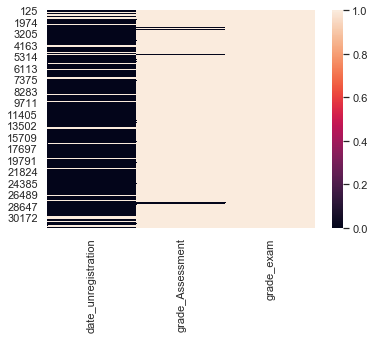

In [18]:
plot(sns.heatmap, df.loc[df._merge == 'left_only', ['date_unregistration', 'grade_Assessment', 'grade_exam']].isna())

In [19]:
pd.set_option('display.max_columns', 100)


In [20]:
no_clickers = df[(df._merge == 'left_only') & (~df.grade_Assessment.isna()) & (df.date_unregistration.isna())].sort_values('date_unregistration')

In [21]:
len(no_clickers)

27

In [22]:
no_clickers

,code_module,code_presentation,id_student,date_registration,date_unregistration,weight_Assessment,weight_Exam,grade_Assessment,grade_Exam,has_grades,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,activity_skew,attention_chi_sq_gof,attention_hellinger_squared,attention_total_variation,clicks_dataplus,clicks_dualpane,clicks_externalquiz,clicks_folder,clicks_forumng,clicks_glossary,clicks_homepage,clicks_htmlactivity,clicks_oucollaborate,clicks_oucontent,clicks_ouelluminate,clicks_ouwiki,clicks_page,clicks_questionnaire,clicks_quiz,clicks_repeatactivity,clicks_resource,clicks_sharedsubpage,clicks_subpage,clicks_url,daily_variability_active,daily_variability_all,days_worked,first_click,last_click,mean_activity_day,mean_click_time_from_release,mean_click_time_to_close,num_materials_available,num_materials_used,total_clicks,weekly_variability,_merge
1474,BBB,2013B,517853,-50.0,NaN,6.0,NaN,71.666667,NaN,both,F,West Midlands Region,Lower Than A Level,10-20,35-55,1,120,N,Fail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2889,BBB,2013J,425817,-53.0,NaN,60.0,NaN,65.050000,NaN,both,M,East Midlands Region,Lower Than A Level,0-10%,35-55,1,90,N,Fail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2920,BBB,2013J,443108,-29.0,NaN,44.0,NaN,61.704545,NaN,both,F,East Midlands Region,A Level or Equivalent,20-30%,0-35,1,60,N,Fail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2972,BBB,2013J,481448,-30.0,NaN,81.0,NaN,62.111111,NaN,both,F,East Anglian Region,Lower Than A Level,60-70%,0-35,1,120,N,Fail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3286,BBB,2013J,544627,-38.0,NaN,45.0,NaN,62.422222,NaN,both,F,East Anglian Region,Lower Than A Level,90-100%,0-35,1,60,N,Fail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3295,BBB,2013J,546195,-10.0,NaN,5.0,NaN,55.000000,NaN,both,M,London Region,Lower Than A Level,0-10%,0-35,0,150,N,Fail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4659,BBB,2013J,2346025,-71.0,NaN,5.0,NaN,39.000000,NaN,both,F,Scotland,Lower Than A Level,50-60%,35-55,2,60,N,Fail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4741,BBB,2013J,2650236,-80.0,NaN,5.0,NaN,60.000000,NaN,both,F,South East Region,Lower Than A Level,20-30%,0-35,1,60,N,Fail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4755,BBB,2014B,38941,-24.0,NaN,5.0,NaN,77.000000,NaN,both,F,East Midlands Region,A Level or Equivalent,10-20,0-35,0,60,N,Fail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
5238,BBB,2014B,560117,-64.0,NaN,61.0,NaN,30.065574,NaN,both,M,West Midlands Region,Lower Than A Level,40-50%,0-35,1,60,N,Fail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [23]:
df.to_csv('dataset.csv')